# Etap III

## Sprawdziany krzyżowe (cross validation), strojenie hiperparametrów, finalne modelowanie

### Krótkie podsumowanie dotychczasowych prac:
W trakcie poszukiwania optymalnego klasyfikatora dla zbioru danych dotyczących pacjentów badanych pod kątem endokrynologicznym w Australii wykonaliśmy:
* eksploracyjnej analizy danych, w trakcie której dowiedzieliśmy się istotnych i ciekawych rzeczy, takich jak niezbalansowanie danych, wpływ poziomu hormonów na inne wskaźniki (np. korelacja TT4 i FTI), przeważająca liczba kobiet wśród badanych oraz że najwięcej pacjentów było z przedziału wiekowego 55-75
* dogłębną inżynierię cech: usunęliśmy puste kolumny, uzupełniliśmy braki danych, zmienne binarne (czyli de facto boolean) zamieniliśmy na 0/1, zakodowaliśmy zmienne kategoryczne
* imputację - zastosowaliśmy szereg metod imputacji danych: wypełnianie wartościami mediany, mody, średniej; zastosowanie algorytmów KNN Imputer oraz Iterative Imputer; zbadaliśmy jak na jakość klasyfikatorów wpłynie różne traktowanie wartości 455 w polu wiek (nie wpłynęło znacząco, potraktujemy tę wartość jako nieznaną)
* kodowanie zmiennych kategorycznych na różne sposoby, które były dwie: sex oraz refferal_source. Płeć kodowaliśmy: target encoding, one hot encoding, jednak zdecydowaliśmy na losowe uzupełnianie z prawdopodobieństwem proporcjonalnym do częstości występowań obu płci w danych bez braków. Zmienna refferal_source również była kodowana przy pomocy TE oraz OHE
* trenowanie modeli: XGBoost oraz RandomForest. Zespoły drzew XGBoost osiągały wysokie i równe wyniki miary Accuracy. Dla miary średniej geometrycznej z TPR i TNR (jej użycie jest wytłumaczone w dalszej części notatnika), nieznacznie niższe wyniki były osiągane przy imputacji Iterative Imputerem (o ok. 2,3 punktu procentowego). Jednocześnie ta funkcja dawała najlepsze rezultaty w Random Forest, lecz jedynie o ok. 0,15 punktu procentowego lepsze niż dla imputacji medianą, wobec czego <u>używać będziemy zbioru danych z Target Encodingiem zmiennej refferal_source oraz imputacją braków przy pomocy mediany.</u>

### Co uznalismy za jeszcze warte wykonania:
* zbadać wpływ standaryzacji (normalizacji) zmiennych ciągłych na jakość algorytmów klasyfikujących
* wykorzystać zautomatyzowane metody strojenia, CV
* wytrenować też prosty model, np. regresja logistyczna oraz model autoML i porównać inne modele względem nich
* spróbować odrzucić jedną z wysoce skorelowanych kolumn oraz informacji o refferal_source, potencjalnie nieprzydatnej i wytrenować na tym modele
* oczywiście sprawdzić skuteczność modeli na danych testowych :)
* zmierzyć jakość modeli przy pomocy miary krzywej ROC (AUC) oraz  krzywej Precision/Recall
* dokonać analizy feature importance oraz porównać ją z początkowymi obserwacjami i założeniami oraz sprawdzić modele dla k najlepszych kolumn a nie całego zbioru





In [0]:
import numpy as np
import pandas as pd
import sklearn
import imblearn
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
import warnings
warnings.filterwarnings('ignore')
from io import StringIO
import requests
from pandas.testing import assert_frame_equal
!pip install category_encoders
import category_encoders as ce
import missingno as mno
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest
from imblearn.metrics import geometric_mean_score
from scipy.stats import poisson, expon, randint
from xgboost import XGBClassifier
! pip install tpot
from tpot import TPOTClassifier
import time
import copy

     |████████████████████████████████| 81kB 2.2MB/s 
     |████████████████████████████████| 163kB 7.7MB/s 
     |████████████████████████████████| 7.1MB 34.8MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp36-none-any.whl size=11956 sha256=a7620ff59bc6255a0ee06f11ff5d1beacdd92d18f86f9d4e9d220415bb48ec5c
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3


In [0]:
# wczytanie danych
whole_data = pd.read_csv('whole-sick-data.csv').drop('Unnamed: 0', axis = 1) # dane przed inzynieria cech - posiadaja zmienne kategoryczne, braki wartosci itp
# niefortunnie wczytuje się także pierwsza kolumna - indeksy
train_data0 = pd.read_csv('train-data-aftersec-milestone.csv').drop('Unnamed: 0', axis = 1)
# dane z zakodowana plcia jako liczby, 'referral_source' jako target encoding, wiek '455' potraktowany jako nan, a wszystkie brakujace wartosci uzupelnione iterative imputer
test_data0 = pd.read_csv('test-data-aftersec-milestone.csv').drop('Unnamed: 0', axis = 1)

Po wczytaniu danych sprawdźmy rozmiar i stopień niezbalansowania oraz proporcje danych w zbiorach testowym i całym, w celu upewnienia się/przypomnienia jakie mamy zbiory.

In [0]:
print('Rozmiar danych treningowych: ' + str(train_data0.shape))
print('Rozmiar danych testowych: ' + str(test_data0.shape))
print('Rozmiar całych danych: {0} oraz jego stopień niezbalansowania: {1:.2f}'.format(whole_data.shape, sum(~whole_data.Thyroid_disease)/sum(whole_data.Thyroid_disease)))

Rozmiar danych treningowych: (3017, 28)
Rozmiar danych testowych: (755, 28)
Rozmiar całych danych: (3772, 28) oraz jego stopień niezbalansowania: 15.33


In [0]:
print("Proporcje targetu w całym zbiorze danych:\n" + str(whole_data.Thyroid_disease.value_counts(True)))
print("\nProporcje targetu w zbiorze testowym:\n" + str(test_data0['Thyroid_disease'].value_counts(True)))

Proporcje targetu w całym zbiorze danych:
False    0.938759
True     0.061241
Name: Thyroid_disease, dtype: float64

Proporcje targetu w zbiorze testowym:
0    0.939073
1    0.060927
Name: Thyroid_disease, dtype: float64


Proporcje są prawidłowe, więc przechodzimy do odzielenia zmiennej celu od naszych zbiorów (zapisując dany zbiór połączylismy je).

## Ponowny podział na dane oraz **etykiety** (zmienna celu)

In [0]:
train_target = train_data0['Thyroid_disease'].to_numpy()
train_data = train_data0.drop('Thyroid_disease', axis = 1)
test_target = test_data0['Thyroid_disease'].to_numpy()
test_data = test_data0.drop('Thyroid_disease', axis = 1)

WAŻNE: Wyciągając wnioski z ostatnich wykładów, spróbujemy wykorzystać miarę średniej geometrycznej (geometric mean - GM) z TPR oraz TNR, jako że jest skuteczna w ocenie klasyfikatorów działających na niezbalansowanych danych.

Drobna uwaga: gdy średnia geometryczna wychodzi 0, oznacza to że minimum jeden z TPR, TNR jest równy 0, niemniej drugi może być wysoki. Warto zastosować jeszcze inną miarę - stosowalismy miary graficzne

## Zbadanie wpływu standaryzacji oraz normalizacji na skuteczność algorytmów klasyfikujących

Przyjmuje się, że warto robić standaryzację/normalizację danych przed modelowaniem, dlatego sprawdzimy, czy zawsze daje to lepsze rezultaty. Do sprawdzenia wykorzystaliśmy klasyfikatory: Random Forest, Regresja Logistyczna oraz XGBoost.

In [0]:
GMscore = make_scorer(geometric_mean_score, average = 'binary')
def examineTransformingInfluence(model, name, score):
    standarizer = StandardScaler()
    minmax = MinMaxScaler()
    standarizing_pipeline = make_pipeline(standarizer, model)
    normalizing_pipeline = make_pipeline(minmax, model)
    CVscores_no_transform = cross_val_score(model, train_data, train_target, cv = KFold(5), scoring=score)
    CVscores_standarization = cross_val_score(standarizing_pipeline, train_data, train_target, cv = KFold(5), scoring=score)
    CVscores_normalization = cross_val_score(normalizing_pipeline, train_data, train_target, cv = KFold(5), scoring=score)
    print(name + ":")
    print('Średnia wyników bez transformacji: {0:.4f}, odchylenie standardowe: {1:.4f}'.format(CVscores_no_transform.mean(), CVscores_no_transform.std()))
    print('Średnia wyników po standaryzacji: {0:.4f}, odchylenie standardowe: {1:.4f}'.format(CVscores_standarization.mean(), CVscores_standarization.std()))
    print('Średnia wyników po normalizacji: {0:.4f}, odchylenie standardowe: {1:.4f}\n'.format(CVscores_normalization.mean(), CVscores_normalization.std()))
lr_model = LogisticRegression(random_state=58, max_iter=2000)
xgb = XGBClassifier()
rf = RandomForestClassifier(random_state = 354)

examineTransformingInfluence(lr_model, 'Regresja logistyczna', GMscore)
examineTransformingInfluence(xgb, 'XGBoost', GMscore)
examineTransformingInfluence(rf, 'Random Forest', GMscore)

Regresja logistyczna:
Średnia wyników bez transformacji: 0.7515, odchylenie standardowe: 0.0690
Średnia wyników po standaryzacji: 0.7816, odchylenie standardowe: 0.0738
Średnia wyników po normalizacji: 0.2892, odchylenie standardowe: 0.0788

XGBoost:
Średnia wyników bez transformacji: 0.9418, odchylenie standardowe: 0.0277
Średnia wyników po standaryzacji: 0.9418, odchylenie standardowe: 0.0277
Średnia wyników po normalizacji: 0.9418, odchylenie standardowe: 0.0277

Random Forest:
Średnia wyników bez transformacji: 0.9058, odchylenie standardowe: 0.0525
Średnia wyników po standaryzacji: 0.9058, odchylenie standardowe: 0.0525
Średnia wyników po normalizacji: 0.9058, odchylenie standardowe: 0.0525



Krótki wniosek - w dalszych krokach warto rozważyć stosowanie standaryzacji.

## Zautomatyzowane szukanie optymalnych parametrów dla różnych modeli

Stworzyliśmy funkcję tuner, która dla pięciu modeli (Random Forest, K Ne-ighbors, Regresji logistycznej, XGBoost oraz GradienBoostingClassifier) sprawdza czy standaryzacja dobrze wpływa na działanie modelu oraz dobiera najlepsze hiperpara-metry (sprawdzając zarówno grid search jak i random search).

In [0]:
def tuner(data_obj, target_obj):
    """
    Funkcja przyjmuje na wejściu ramke danych - zmienne objaśniające oraz zmienną celu.
    Wykonuje strojenie hiperparametrów oraz porównanie jakości algorytmów klasyfikujących w zależności od staandaryzacji danych
    Dla każdego spośród klasyfikatorów: Random Forest, K Neighbors, Regresji logistycznej, XGBoost oraz GradienBoostingClassifier wykonuje poszukiwanie optymalnego zestawu hiperparametrów,
    zarówno za pomocą 'siatki poszukiwań' jak i losowo, biorąc pod uwagę wskazane wartości.
    W trakcie swojej pracy, funkcja wypisuje dla każdego modelu najlepiej nastrojony zestaw, zarówno dla poszukiwania losowego, jak i w siatce.
    Ponadto informuje, czy w tym przypadku zastosowanie standaryzacji przyniosło korzyść.   
    Zwracaną wartością jest słownik pieciu obiektów typu RandomizedSearchCV bądź GridSearchCV - w zaleznosci ktory byl najlepszy.
    Z każdego takiego obiektu można wyłuskać najlepszy estymator za pomocą parametru .best_estimator_
    """
    modeldict = {
    'RandomForestClassifier': RandomForestClassifier(random_state=12),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(random_state=342),
    'XGBClassifier': XGBClassifier(random_state=23),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=67)
    }

    params = {
    'RandomForestClassifier':{ 
            "randomforestclassifier__n_estimators": [100, 200, 500, 1000],
            "randomforestclassifier__max_features": ["auto", "log2"],
            "randomforestclassifier__criterion": ['gini', 'entropy'],
            "randomforestclassifier__max_depth": [None, 3, 7]
            },
    'KNeighborsClassifier': {
        'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],
        'kneighborsclassifier__weights': ['uniform', 'distance'],
        'kneighborsclassifier__algorithm': ['ball_tree', 'kd_tree', 'brute']
        },
    'LogisticRegression': {
        'logisticregression__solver': ['newton-cg', 'sag', 'lbfgs'],
        'logisticregression__max_iter': [100, 300]
        },
    'XGBClassifier': {
        'xgbclassifier__max_depth': [3, 5, 8],
        'xgbclassifier__learning_rate': [0.05, 0.1, 0.5],
        'xgbclassifier__booster': ['gbtree', 'dart']
        },
    'GradientBoostingClassifier': {
        'gradientboostingclassifier__n_estimators': [100, 400, 800],
        'gradientboostingclassifier__learning_rate': [0.1, 0.5],
        'gradientboostingclassifier__min_samples_split': [1, 3],
        'gradientboostingclassifier__max_depth': [3, 8, 10],
        'gradientboostingclassifier__ccp_alpha': [0.0, 0.9]
        }
    }
    params_random = {
    'RandomForestClassifier':{ 
            "randomforestclassifier__n_estimators": randint(low = 50, high = 1300),#random.sample(range(50, 1300), 3),
            "randomforestclassifier__max_features": ["auto", "log2"],
            "randomforestclassifier__criterion": ['gini', 'entropy'],
            "randomforestclassifier__max_depth": [None] + random.sample(range(1, 15), 2)
            },
    'KNeighborsClassifier': {
        'kneighborsclassifier__n_neighbors': randint(low = 1, high = 15),#random.sample(range(1, 15), 3),
        'kneighborsclassifier__weights': ['uniform', 'distance'],
        'kneighborsclassifier__algorithm': ['ball_tree', 'kd_tree', 'brute']
        },
    'LogisticRegression': {
        'logisticregression__solver': ['newton-cg', 'sag', 'lbfgs'],
        'logisticregression__max_iter': randint(low = 100, high = 800),#random.sample(range(100, 800), 3)
        },
    'XGBClassifier': {
        'xgbclassifier__max_depth': [None] + random.sample(range(2, 12), 3),
        'xgbclassifier__learning_rate': expon(0.08),
        'xgbclassifier__booster': ['gbtree', 'dart']
        },
    'GradientBoostingClassifier': {
        'gradientboostingclassifier__n_estimators': randint(low = 50, high = 1300),#random.sample(range(50, 1300), 2),
        'gradientboostingclassifier__learning_rate': expon(0.08),
        'gradientboostingclassifier__min_samples_split': randint(low = 1, high = 8),#random.sample(range(1, 8), 2),
        'gradientboostingclassifier__max_depth': randint(low = 2, high = 15),#random.sample(range(2, 15), 2),
        'gradientboostingclassifier__ccp_alpha': expon(0.06)
        }
    }
    A = {}
    standarizer = StandardScaler()
    for modelname in modeldict.keys():
        model = modeldict[modelname]
        param = params[modelname]
        param_random = params_random[modelname]
        standarizing_pipeline = make_pipeline(standarizer, model)
        simple_pipeline = make_pipeline(model)
        searcher = GridSearchCV(simple_pipeline, param_grid=param, cv=5, scoring = GMscore, n_jobs = -1)
        searcher_with_standarization = GridSearchCV(standarizing_pipeline, param_grid=param, cv = 5, scoring = GMscore)
        searcher.fit(data_obj, target_obj)
        searcher_with_standarization.fit(data_obj, target_obj)
        if searcher.best_score_ >= searcher_with_standarization.best_score_:
            GSCV = searcher 
            gstnd = "NOT standarized"
        else:
            GSCV = searcher_with_standarization
            gstnd = "STANDARIZED"
        randomsearcher = RandomizedSearchCV(simple_pipeline, param_distributions=param_random, cv = 5, n_jobs=-1, random_state=59, scoring = GMscore)
        randomsearcher_with_standarization = RandomizedSearchCV(standarizing_pipeline, param_distributions= param_random, cv = 5, n_jobs=-1, random_state=59, scoring = GMscore)
        randomsearcher.fit(data_obj, target_obj)
        randomsearcher_with_standarization.fit(data_obj, target_obj)
        if randomsearcher.best_score_ >= randomsearcher_with_standarization.best_score_:
            RSCV = randomsearcher
            rstnd = "NOT standarized"
        else:
            RSCV = randomsearcher_with_standarization
            rstnd = "STANDARIZED"
        print(modelname + ':')
        print("Random Search CV:\nBest parameters are:\n{0}\n{1}\nThe score: {2:.6f}".format(RSCV.best_params_, rstnd, RSCV.best_score_))
        print("Grid Search CV:\nBest parameters are:\n{0}\n{1}\nThe score: {2:.6f}\n".format(GSCV.best_params_, gstnd, GSCV.best_score_))
        best_model = GSCV if GSCV.best_score_ >= RSCV.best_score_ else RSCV
        A.update({modelname: best_model})
    return A

### Testowanie dla naszego wybranego zbioru

In [0]:
#ponad 15 min - zaparz herbatę. Albo 5.
dict_of_best_classifiers = tuner(train_data, train_target)

RandomForestClassifier:
Random Search CV:
Best parameters are:
{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__n_estimators': 630}
STANDARIZED
The score: 0.915979
Grid Search CV:
Best parameters are:
{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__n_estimators': 200}
NOT standarized
The score: 0.922336

KNeighborsClassifier:
Random Search CV:
Best parameters are:
{'kneighborsclassifier__algorithm': 'kd_tree', 'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'distance'}
STANDARIZED
The score: 0.718243
Grid Search CV:
Best parameters are:
{'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'distance'}
STANDARIZED
The score: 0.718243

LogisticRegression:
Random Search CV:
Be

Wnioski:
- w każdym z przypadków stosowanie siatki poszukiwania optymalnych parametrów przynosiło nie gorsze rezultaty (czasami nawet lepsze)
- standaryzacja danych wejściowych przynosi korzyści w przypadku algorytmów Regresji logistycznej, K Neighbors i czasem też dla Random Forest
- bezwzględnie najlepszym modelem okazał się XGBoost


Zobaczmy rezultaty dla najlepszego modelu.

In [0]:
pd.DataFrame(dict_of_best_classifiers['XGBClassifier'].cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__booster,param_xgbclassifier__learning_rate,param_xgbclassifier__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.341137,0.023096,0.006137,0.001594,gbtree,0.05,3,"{'xgbclassifier__booster': 'gbtree', 'xgbclass...",0.943567,0.851979,0.911283,0.954359,0.985522,0.929342,0.045377,5
1,0.451950,0.007179,0.004869,0.000100,gbtree,0.05,5,"{'xgbclassifier__booster': 'gbtree', 'xgbclass...",0.929161,0.819817,0.912906,0.970878,0.972598,0.921072,0.055714,17
2,0.510904,0.011610,0.004890,0.000124,gbtree,0.05,8,"{'xgbclassifier__booster': 'gbtree', 'xgbclass...",0.929161,0.836053,0.898061,0.970878,0.972598,0.921350,0.050908,15
3,0.320622,0.005787,0.005429,0.000253,gbtree,0.1,3,"{'xgbclassifier__booster': 'gbtree', 'xgbclass...",0.942733,0.882970,0.928337,0.956907,0.972598,0.936709,0.030627,3
4,0.469943,0.014517,0.005699,0.000280,gbtree,0.1,5,"{'xgbclassifier__booster': 'gbtree', 'xgbclass...",0.957757,0.836794,0.898061,0.971738,0.972598,0.927389,0.052916,7
5,0.514096,0.010894,0.005633,0.000284,gbtree,0.1,8,"{'xgbclassifier__booster': 'gbtree', 'xgbclass...",0.957757,0.820544,0.898061,0.970878,0.972598,0.923967,0.058438,13
6,0.315244,0.005405,0.005886,0.000299,gbtree,0.5,3,"{'xgbclassifier__booster': 'gbtree', 'xgbclass...",0.928339,0.913719,0.898858,0.971738,0.971738,0.936878,0.029951,1
7,0.383033,0.015222,0.006214,0.000567,gbtree,0.5,5,"{'xgbclassifier__booster': 'gbtree', 'xgbclass...",0.929161,0.836053,0.912906,0.971738,0.972598,0.924491,0.050048,11
8,0.393329,0.013401,0.005867,0.000116,gbtree,0.5,8,"{'xgbclassifier__booster': 'gbtree', 'xgbclass...",0.943567,0.836794,0.912906,0.971738,0.958603,0.924721,0.048134,9
9,0.629818,0.028771,0.005117,0.000150,dart,0.05,3,"{'xgbclassifier__booster': 'dart', 'xgbclassif...",0.943567,0.851979,0.911283,0.954359,0.985522,0.929342,0.045377,5


### Testowanie dla zbioru danych bez kolumn 'measured_'

Próba sprawdzenia czy wyniki są wtedy lepsze.


In [0]:
no_measured_train_data = train_data.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured'], axis = 1)
no_measured_test_data = test_data.drop(['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured'], axis = 1)

In [0]:
no_measured_dict_of_best_classifiers = tuner(no_measured_train_data, train_target)

RandomForestClassifier:
Random Search CV:
Best parameters are:
{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 553}
NOT standarized
The score: 0.903882
Grid Search CV:
Best parameters are:
{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__n_estimators': 1000}
STANDARIZED
The score: 0.903894

KNeighborsClassifier:
Random Search CV:
Best parameters are:
{'kneighborsclassifier__algorithm': 'kd_tree', 'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'distance'}
STANDARIZED
The score: 0.703292
Grid Search CV:
Best parameters are:
{'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'distance'}
STANDARIZED
The score: 0.703292

LogisticRegression:
Random Search 

Wniosek - usunięcie kolumn `_measured` okazało się nie mieć pozytywnego wpływu na skuteczność algorytmów - jedynie Regresja logistyczna osiągnęła nieznacznie wyższe wyniki. Wartości optymalnych parametrów się zmieniały - dla przykładu wzrost liczby estymatorów z 200 do 1000 dla Random Foresta z Grid Searchem. Bezwzględnie najlepszy ponownie okazał się XGBoost. 

### Testowanie przy redukcja wymiarów: usunięcie TT4 skorelowanego z FTI oraz referral_source

Przypomnijmy, współczynnik korelacji między FTI a TT4 wyniósł 0.79, a referral_source jest informacją o szpitalu, z którego wzięto dane co powinno być nieprzydatne do oceny choroby.


In [0]:
reduced_train_data = train_data.drop(['TT4_measured', 'TT4', 'referral_source'], axis = 1)

In [0]:
reduced_dict_of_best_classificators = tuner(reduced_train_data, train_target)

RandomForestClassifier:
Random Search CV:
Best parameters are:
{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 553}
STANDARIZED
The score: 0.890266
Grid Search CV:
Best parameters are:
{'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__n_estimators': 200}
NOT standarized
The score: 0.895893

KNeighborsClassifier:
Random Search CV:
Best parameters are:
{'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 4, 'kneighborsclassifier__weights': 'distance'}
STANDARIZED
The score: 0.727376
Grid Search CV:
Best parameters are:
{'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'distance'}
STANDARIZED
The score: 0.714999

LogisticRegression:
Random Search

Modyfikacja zbiorów danych ponownie nie przyniosła poprawienia modeli. Zdecydowana większość spośród najlepszych wyników była niższa w porównaniu ze zbiorem ze wszystkimi kolumnami (wyjątek - K Neighbours, który i tak przynosi słabe efekty). Czas działania funkcji po usunięciu kolumn, jeśli został zmniejszony to nieznacznie - nie przeprowadzaliśmy dokładnych testów. 
Można by rzec, że jednak te kolumny nie mają dużego wpływu, stąd pytanie jakie mają wpływ na ocenę choroby tarczycy - na razie będziemy działać na podstawowym, niezmienionym zbiorze, jednak do tematu wyboru kolumn wrócimy na koniec.

## OSTATECZNIE NIEWYKORZYSTANE - wróćmy do naszych pierwszych najlepszych modeli i je podsumujmy


In [0]:
# def removefromdict(slownik, klucz):
#     r = copy.deepcopy(slownik)
#     del r[klucz]
#     return r
# selected_classifiers = removefromdict(dict_of_best_classifiers, 'KNeighborsClassifier')
# selected_classifiers = removefromdict(selected_classifiers, 'GradientBoostingClassifier')
# #selected_classifiers1 = dict_of_best_classifiers

In [0]:
# best_pipelines = [selected_classifiers[j].best_estimator_ for j in selected_classifiers.keys() ]

## Sprawdzenie najlepszych klasyfikatorów na danych testowych

Wiemy już jakie parametry dają najlepsze wyniki dal naszych 5 modeli, dlatego pora sprawdzić ich wyniki na danych testowych, czyli tym co rzeczywiście chcemy przewidzieć. Wykorzystamy miary: GM, krzywa ROC, krzywa Precision-Recall.

In [0]:
def test_models(data_test, target_test, pplns):
    """
    Funckja przyjmuje testowe dane oraz listę wartości zmiennej objaśnianej i listę obiektów typu Pipeline do sprawdzenia oraz wizualizacji ich skuteczności.
    Rezultatem jej działaniea jest wypisanie wartości średnich geometrycznych oraz prezentacja wykresów: ROC AUC i precision-recall curve
    """
    i=0
    precision = [0]*len(pplns)
    recall = [0]*len(pplns)
    listap = [0]*len(pplns)
    tpr = [0]*len(pplns)
    fpr = [0]*len(pplns)
    listauc = [0]*len(pplns)
    listaucpred = [0]*len(pplns)
    names = [0]*len(pplns)
    for pipe in pplns:
        pipename = pipe.steps[0][0] if pipe.steps[0][0] != 'standardscaler' else pipe.steps[1][0]
        names[i] = pipename
        y_pred = pipe.predict(data_test)
        #print("Classification report of model {0}:\n{1}".format(pipename, classification_report(target_test, y_pred)))
        print('GM score for {0} model: {1:.6f}\n'.format(pipename, geometric_mean_score(target_test, y_pred, average='binary')))
        probabilities = pipe.predict_proba(data_test)[:, 1] 
        precision[i] = dict()
        recall[i] = dict()
        listap[i] = dict()
        tpr[i] = dict()
        fpr[i] = dict()
        listauc[i] = dict()
        fpr[i], tpr[i], _ = roc_curve(target_test, probabilities)
        listauc[i] = auc(fpr[i], tpr[i])
        precision[i], recall[i], _ = precision_recall_curve(target_test, probabilities)
        listaucpred[i] = auc(recall[i], precision[i])
        listap[i] = average_precision_score(target_test, probabilities)
        i+=1
    lw = 2
    colors = ['red', 'green', 'blue', 'orange', 'yellow'] ### gdy pipelinow jest wiecej, nalezy rozszerzyc
    labels = []
    lines = []
    ## Pierwszy wykres - P/R
    plt.figure(figsize=(10, 6))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-recall curve')
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    labels.append('iso-f1 curves')
    lines.append(l)
    for j in range(i):
        l, = plt.plot(precision[j], recall[j], color=colors[j], lw=lw)
        lines.append(l)
        labels.append('Precision-recall for {0} (AP = {1:0.2f}, AUC = {2:.2f})'.format(names[j], listap[j], listaucpred[j]))
    plt.legend(lines, labels, loc=(0, 0.08), prop=dict(size=9))
    plt.show()
    ##Drugi wykres - ROC
    plt.figure(figsize=(10, 6))
    for j in range(i):
        plt.plot(fpr[j], tpr[j], color=colors[j], lw=lw, label='{0} ROC curve (area = {1:.2f})'.format(names[j], listauc[j]))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()



GM score for randomforestclassifier model: 0.894321

GM score for kneighborsclassifier model: 0.569023

GM score for logisticregression model: 0.688632

GM score for xgbclassifier model: 0.892416

GM score for gradientboostingclassifier model: 0.918825



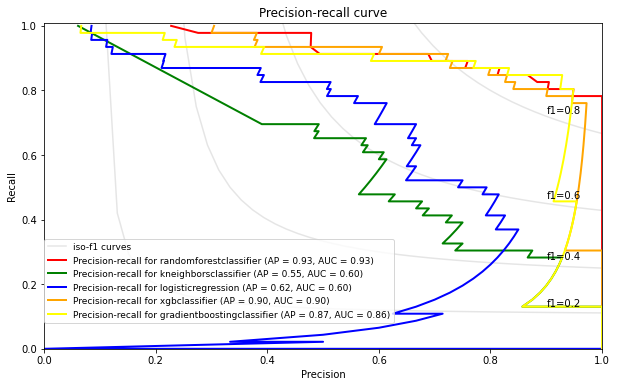

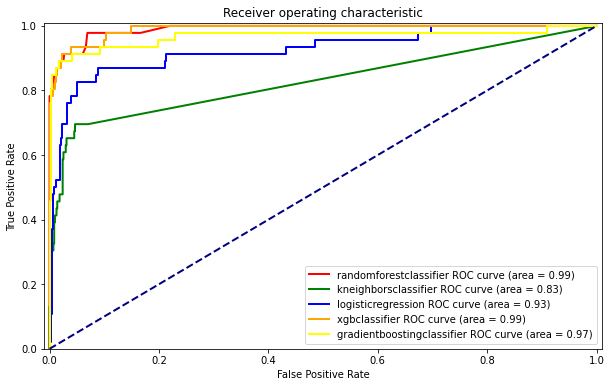

In [0]:
best_pipelines1 = [dict_of_best_classifiers[j].best_estimator_ for j in selected_classifiers1.keys() ]
test_models(test_data, test_target, best_pipelines1)

W każdej z trzech miar, najmniej efektywnymi modelami są K Neighbor i Regresja Logistyczna.
W graficznych miarach najlepiej prezentuje się Random Forest (kolor czerwony), choć pod względem średniej geometrycznej plasuje się na drugiej pozycji, za Gradient Boosting Classifierem.

## Analiza Feature Importance dla najlepszych modeli

Wiemy już jaki model jest najlepszy na zbiorze testowym, jednak okazało się, że usunięcie niektórych kolumn wcale nie pogorsza zbytnio wyników, dlatego przyjrzyjmy się jakie kolumny mają rzeczywisty wpływ na przewidywanie.

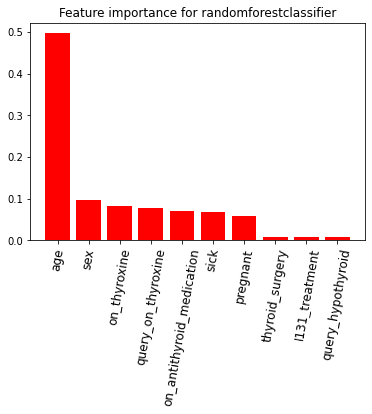

Feature importance not available for model: kneighborsclassifier
Feature importance not available for model: logisticregression


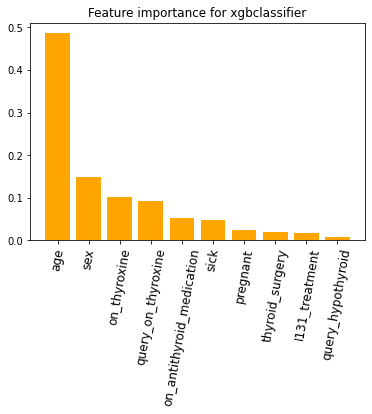

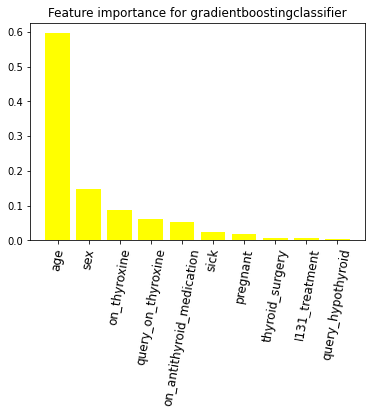

In [0]:
def featureimportances(data_test, target_test, pplns):
    i = 0
    colors = ['red', 'green', 'blue', 'orange', 'yellow']
    for pipe in pplns:
        pipename = pipe.steps[0][0] if pipe.steps[0][0] != 'standardscaler' else pipe.steps[1][0]
        try:
            rf_importances = pipe.steps[0][1].feature_importances_ if pipe.steps[0][0] != 'standardscaler' else pipe.steps[1][1].feature_importances_
        except:
            print('Feature importance not available for model: ' + pipename)
            i+=1
            continue
        indices = np.argsort(rf_importances)[::-1]
        plt.figure()
        plt.title("Feature importance for " + pipename)
        plt.bar(train_data.columns[0:10], rf_importances[indices][0:10],
           color=colors[i], align="center")
        plt.xticks(rotation=80, size = 12)
        plt.show()
        i += 1

featureimportances(test_data, test_target, best_pipelines1)

Dla sprawdzonych modeli można zauważyć, że to te same kolumny mają największy wpływ. Sprawdźmy teraz, czy modele wykorzystujące k najlepszych kolumn z feature importance mają lepsze czy gorsze wyniki.


## Wybieranie k najlepszych zmiennych przy pomocy SelectKBest()

Badanie zostanie przeprowadzone dla trzech najlepszych modeli: Random Forest, XGBClassifier, Gradient Boosting Classifier. Sprawdzilismy krzywe ROC i Precision-Recall oraz GM Score dla 3,
5, 7, 9, 11 i wszystkich kolumn.

 GM score for randomforestclassifier: 0.837982; Number of selected features: 3, time of working: 0.446007s.

 GM score for randomforestclassifier: 0.853642; Number of selected features: 5, time of working: 0.510625s.

 GM score for randomforestclassifier: 0.893686; Number of selected features: 7, time of working: 0.513846s.

 GM score for randomforestclassifier: 0.905683; Number of selected features: 9, time of working: 0.555553s.

 GM score for randomforestclassifier: 0.893686; Number of selected features: 11, time of working: 0.519911s.

 GM score for randomforestclassifier: 0.894321; Number of selected features: all, time of working: 0.580486s.



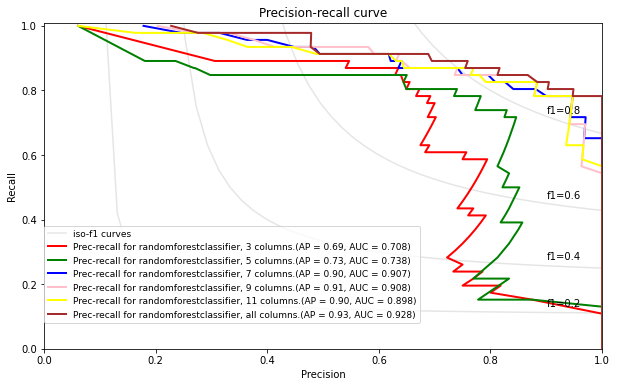

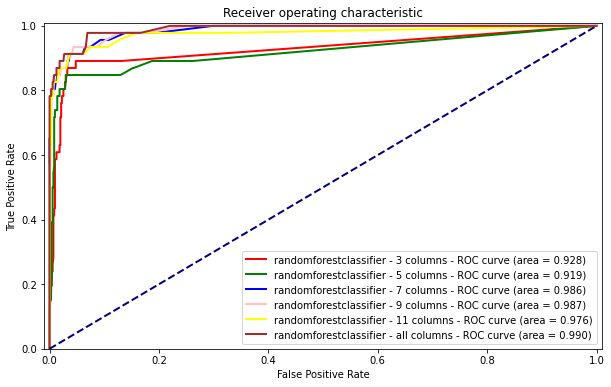

 GM score for xgbclassifier: 0.799560; Number of selected features: 3, time of working: 0.108383s.

 GM score for xgbclassifier: 0.864244; Number of selected features: 5, time of working: 0.120796s.

 GM score for xgbclassifier: 0.890507; Number of selected features: 7, time of working: 0.133147s.

 GM score for xgbclassifier: 0.890507; Number of selected features: 9, time of working: 0.138912s.

 GM score for xgbclassifier: 0.890507; Number of selected features: 11, time of working: 0.152393s.

 GM score for xgbclassifier: 0.892416; Number of selected features: all, time of working: 0.248681s.



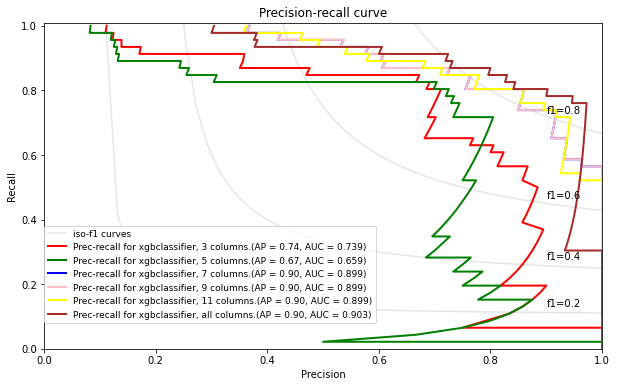

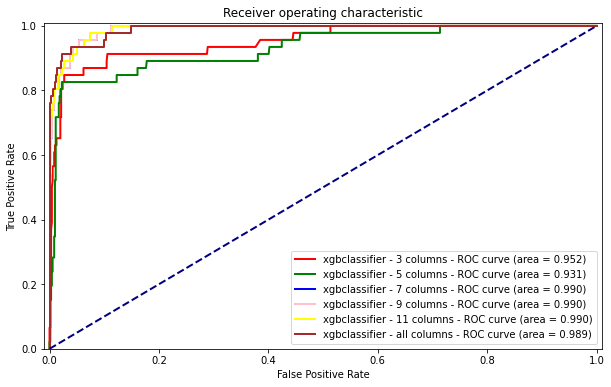

 GM score for gradientboostingclassifier: 0.827562; Number of selected features: 3, time of working: 0.196538s.

 GM score for gradientboostingclassifier: 0.799560; Number of selected features: 5, time of working: 0.247392s.

 GM score for gradientboostingclassifier: 0.925243; Number of selected features: 7, time of working: 0.312801s.

 GM score for gradientboostingclassifier: 0.913604; Number of selected features: 9, time of working: 0.306766s.

 GM score for gradientboostingclassifier: 0.900522; Number of selected features: 11, time of working: 0.319359s.

 GM score for gradientboostingclassifier: 0.918825; Number of selected features: all, time of working: 0.488302s.



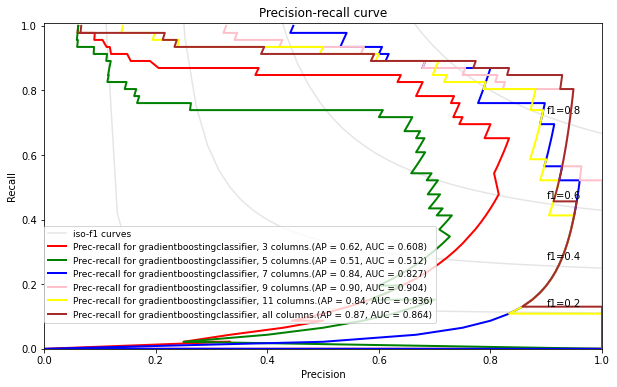

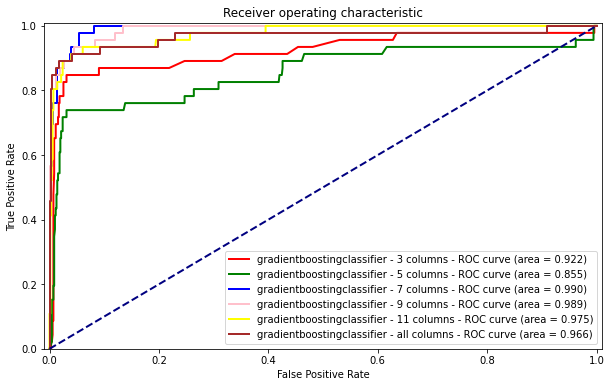

In [0]:
rf_gbc_xgb = [j.steps[0] for j in best_pipelines1 if j.steps[0][0] in ['randomforestclassifier', 'gradientboostingclassifier', 'xgbclassifier']]
#select_k_ppln = [Pipeline([
 #          ('select', SelectKBest(k = list_of_k)),
  #         ('model', m)]) for m in rf_gbc for list_of_k in [3, 5, 7, 9]]

def check_selecting(datatrain, targettrain, datatest, targettest, list_of_model, list_of_k):
    """modyfikacja funkcji test_models na potrzeby oceny modeli po wybraniu k modeli"""
    i=0
    precision = [0]*(len(list_of_model)*len(list_of_k))
    recall = [0]*(len(list_of_model)*len(list_of_k))
    listap = [0]*(len(list_of_model)*len(list_of_k))
    tpr = [0]*(len(list_of_model)*len(list_of_k))
    fpr = [0]*(len(list_of_model)*len(list_of_k))
    listauc = [0]*(len(list_of_model)*len(list_of_k))
    listaucpred = [0]*(len(list_of_model)*len(list_of_k))
    names = [0]*(len(list_of_model)*len(list_of_k))
    for model in list_of_model:
        for k in list_of_k:
            ppl = Pipeline([
                      ('select', SelectKBest(k = k)),
                      ('model', model[1])
            ])
            t0 = time.time()
            ppl.fit(datatrain, targettrain)
            y_pred = ppl.predict(datatest)
            t1 = time.time()
            score = geometric_mean_score(targettest, y_pred, average = 'binary')
            print(" GM score for {0}: {1:.6f}; Number of selected features: {2}, time of working: {3:.6f}s.\n".format(model[0], score, k, t1-t0))
            pipename = model[0]
            names[i] = pipename
            probabilities = ppl.predict_proba(datatest)[:, 1]
            precision[i] = dict()
            recall[i] = dict()
            listap[i] = dict()
            tpr[i] = dict()
            fpr[i] = dict()
            listauc[i] = dict()
            fpr[i], tpr[i], _ = roc_curve(targettest, probabilities)
            listauc[i] = auc(fpr[i], tpr[i])
            precision[i], recall[i], _ = precision_recall_curve(targettest, probabilities)
            listaucpred[i] = auc(recall[i], precision[i])
            listap[i] = average_precision_score(targettest, probabilities)
            i+=1
        lw = 2
        colors = ['red', 'green', 'blue', 'pink', 'yellow', 'brown'] ### gdy pipelinow jest wiecej, nalezy rozszerzyc
        labels = []
        lines = []
        ## Pierwszy wykres - P/R
        plt.figure(figsize=(10, 6))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.01])
        plt.xlabel('Precision')
        plt.ylabel('Recall')
        plt.title('Precision-recall curve')
        f_scores = np.linspace(0.2, 0.8, num=4)
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
            plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
        labels.append('iso-f1 curves')
        lines.append(l)
        for j in range(i):
            l, = plt.plot(precision[j], recall[j], color=colors[j], lw=lw)
            lines.append(l)
            labels.append('Prec-recall for {0}, {3} columns.(AP = {1:0.2f}, AUC = {2:.3f})'.format(names[j], listap[j], listaucpred[j], list_of_k[j]))
        plt.legend(lines, labels, loc=(0, 0.08), prop=dict(size=9))
        plt.show()
        ##Drugi wykres - ROC
        plt.figure(figsize=(10, 6))
        for j in range(i):
            plt.plot(fpr[j], tpr[j], color=colors[j], lw=lw, label='{0} - {2} columns - ROC curve (area = {1:.3f})'.format(names[j], listauc[j], list_of_k[j]))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([-0.01, 1.01])
        plt.ylim([0.0, 1.01])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        i = 0

check_selecting(train_data, train_target, test_data, test_target, rf_gbc_xgb, [3, 5, 7, 9, 11, 'all'])

Dla RandomForest i XGB najlepsze wyniki miał model wykonany na pełnej ramce danych. Najlepszy okazał się Gradient Boosting. 

**Gradient Boosting Classifier dla wybranych 7 zmiennych osiągnął niespotykaną dotąd skuteczność GM score 0.925, choć miara graficzna Precision - Recall wykazała, że wybranie 9 kolumn byłoby jeszcze lepsze.**

## Automatyczny wybór modelu - porównanie automatycznego klasyfikatora z już sprawdzonymi modelami




In [0]:
tpot = TPOTClassifier(generations=5,verbosity=2, random_state=234, scoring=GMscore, n_jobs = -2)

tpot.fit(train_data, train_target)

Generation 1 - Current best internal CV score: 0.9404353788878606
Generation 2 - Current best internal CV score: 0.9404353788878606
Generation 3 - Current best internal CV score: 0.9596752553587955
Generation 4 - Current best internal CV score: 0.9596752553587955
Generation 5 - Current best internal CV score: 0.9723751425263352

Best pipeline: XGBClassifier(RandomForestClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.2, min_samples_leaf=5, min_samples_split=16, n_estimators=100), learning_rate=0.001, max_depth=6, min_child_weight=15, n_estimators=100, nthread=1, subsample=0.25)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=5,
               max_eval_time_mins=5, max_time_mins=None, memory=None,
               mutation_rate=0.9, n_jobs=-2, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=100,
               random_state=234,
               scoring=make_scorer(geometric_mean_score, average=binary),
               subsample=1.0, template=None, use_dask=False, verbosity=2,
               warm_start=False)

In [0]:
tpot.score(test_data, test_target)

0.9232522283387784

Wniosek - automatyczne wyszukanie optymalnego klasyfikatora przyniosło bardzo dobry wynik, jednak nieco gorszy niż Gradient Boosting Classifier dla wybranych 7 zmiennych.

## Podsumowanie projektu

Krótko podsumowując, najlepsza inżynieria cech dla zbioru sick to: sex zakodowanana 0,1 z wartościami imputowanymi losowo, refferal_source zakodowana target encodingiem, age równy 455 jako NaN, a zmienne numeryczne zaimputowane medianą. A wedle wykorzystanych miar ogólnie najlepszym klasyfikatorem okazał się Gradient Boosting Classifier. Natomiast najsłabszymi modelami okazały się Regresja logistyczna oraz K Neighbors.